In [1]:
# import
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import random
import torch.nn as nn
import torch.nn.functional as F
import warnings
import datetime
from copy import deepcopy

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(777)

In [3]:
sns.set()
plt.rcParams['figure.figsize'] = (24, 18)        
plt.rcParams['image.interpolation'] = 'nearest'  
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18


In [4]:
def data_continuous_discrete(n_samples, dim, test_type, noise="gaussian", seed=None):
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if noise == "gaussian":
        sampler = np.random.normal
    elif noise == "laplace":
        sampler = np.random.laplace
    elif noise == "uniform":
        sampler = np.random.uniform
        
        
    
    
    if dim ==1:
        z = sampler(size=(n_samples, 1))
        
        
        
        
        if test_type:
            eps1=0.33*sampler(size=(n_samples, 1))
            eps2=0.33*sampler(size=(n_samples, 1))
            x = z+eps1
            y = z+eps2
        else:
            eps1=0.33*sampler(size=(n_samples, 1))
            x = z+eps1
            y = z+eps1

        
            
    else:
        z = np.zeros(shape=(n_samples, dim))
        z[:,0:int(dim/2)]=sampler(size=(n_samples, int(dim/2)))
        z[:,int(dim/2):]=np.random.binomial(1,0.5,z[:,int(dim/2):].shape)*2-1
        
        
        
        
        if test_type:
            eps1=0.33*sampler(size=(n_samples, 1))
            eps2=0.33*sampler(size=(n_samples, 1))

            x=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
            y=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps2
        else:
            eps1=0.33*sampler(size=(n_samples, 1))
            x=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
            y=np.mean(z[:,0:int(2*dim/3)], axis=1).reshape(-1, 1)+eps1
        


    return x, y, z, 'continuous_discrete', 'continuous_discrete'

In [5]:
device = torch.device('cuda')
dz=20
num=500
dataset_y,_,dataset_x,_,_=data_continuous_discrete(n_samples=num, dim=dz, test_type=True, noise="gaussian", seed=999)
dataset_y=torch.tensor(dataset_y).float().to(device)
dataset_x=torch.tensor(dataset_x).float().to(device)

In [6]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, t):
        out = self.lin(x)
        gamma = self.embed(t)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalGuidedModel(nn.Module):
    def __init__(self, num_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(dz+1, 16, num_steps)
        self.lin2 = ConditionalLinear(16, 16, num_steps)
        self.lin3 = ConditionalLinear(16, 16, num_steps)
        self.lin4 = nn.Linear(16, 1)

    def forward(self, x, y_t, t):
        eps_pred = torch.cat((x, y_t,), dim=1)
        eps_pred = F.softplus(self.lin1(eps_pred, t))
        eps_pred = F.softplus(self.lin2(eps_pred, t))
        eps_pred = F.softplus(self.lin3(eps_pred, t))
        return self.lin4(eps_pred)

In [7]:
num_steps=1000
def score_loss_fn(model, y_0, x, n_steps,device):
    batch_size = y_0.shape[0]
    t = torch.randint(1, n_steps, size=(batch_size,), device=device) # t_min=1/n_step
    t_input = t.unsqueeze(-1)  # priorly set T=1000/100=10
    t_compute=t.unsqueeze(-1) /100
    epsilon=torch.normal(0,1,(batch_size,1)).to(device)
    y_input=torch.exp(-t_compute/2)*y_0+torch.sqrt(1-torch.exp(-t_compute))*epsilon
    output = model(x, y_input, t_input.squeeze(-1))
    loss=(output+(y_input-torch.exp(-t_compute/2)*y_0)/(1-torch.exp(-t_compute))).square().mean()
    return loss

In [8]:
#train
import datetime
print('training model...')
batch_size=2048
dataloader=torch.utils.data.DataLoader(torch.cat([dataset_x,dataset_y],dim=1),batch_size=batch_size,shuffle=True)
plt.rc('text',color='blue')
model = ConditionalGuidedModel(num_steps).to(device)
lr=1e-2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
num_epoch = 1500
loss_fn2=nn.MSELoss()
for z in range(num_epoch):
    total_loss=0
    for idx,batch in enumerate (dataloader):
        start = datetime.datetime.now()
        batch_x = batch[:,:dz]
        batch_y = batch[:,dz:]
        loss=score_loss_fn(model, batch_y, batch_x, 1000,device)
        total_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        end = datetime.datetime.now()
    if z%50==0:
        print(f'{z} epoch,use time:{end-start}, loss:{total_loss} ')

training model...
0 epoch,use time:0:00:00.428124, loss:1.5233391523361206 
50 epoch,use time:0:00:00.003999, loss:0.5902919173240662 
100 epoch,use time:0:00:00.003005, loss:0.12604376673698425 
150 epoch,use time:0:00:00.004001, loss:0.8382299542427063 
200 epoch,use time:0:00:00.004000, loss:0.19392266869544983 
250 epoch,use time:0:00:00.004000, loss:0.36380067467689514 
300 epoch,use time:0:00:00.003999, loss:0.30129721760749817 
350 epoch,use time:0:00:00.003001, loss:0.7121077179908752 
400 epoch,use time:0:00:00.004000, loss:0.4115716814994812 
450 epoch,use time:0:00:00.003000, loss:0.41714125871658325 
500 epoch,use time:0:00:00.004000, loss:0.19582073390483856 
550 epoch,use time:0:00:00.003000, loss:0.30694612860679626 
600 epoch,use time:0:00:00.003000, loss:0.06401626765727997 
650 epoch,use time:0:00:00.007011, loss:1.0294214487075806 
700 epoch,use time:0:00:00.004000, loss:1.8862651586532593 
750 epoch,use time:0:00:00.004000, loss:0.10484816133975983 
800 epoch,use ti

In [9]:
def score_sampler(model,shape,x, device,sample_steps=1000,):
    model.eval()
    tK_mins_t0=(1000-1)/100 
    delta_t=torch.tensor([tK_mins_t0/sample_steps],device=device) 
    y_k=torch.normal(0,1,(shape)).to(device)
    with torch.no_grad():
        for t in range(1,sample_steps):
            eps=torch.normal(0,(tK_mins_t0/sample_steps)**0.5,(shape)).to(device)
            t_input=torch.tensor([sample_steps-t],device=device)
            y_k=y_k+eps+delta_t*(0.5*y_k+model(x,y_k,t_input)) # t_input from 999 to 1
    return y_k

In [10]:
quantile_005=0.05
quantile_025=0.25
quantile_050=0.50
quantile_075=0.75
quantile_095=0.95
result=[]
repeat=100
num_test=500
for i in range(repeat): 
    seed_everything(i+3)
    print(i)
    z_fix=(torch.ones(num_test,int(dz/2))*torch.randn((1,int(dz/2)))).to(device)
    binominal_fix=np.ones((num_test,int(dz/2)))*np.random.binomial(1,0.5,(1,int(dz/2)))
    binominal_fix=torch.tensor(binominal_fix).float().to(device)
    z_fix=torch.cat([z_fix,binominal_fix],axis=1)



    y_fix=torch.mean(z_fix[:,:int(2*dz/3)],axis=1).reshape(-1,1)+0.33*torch.randn((num_test,1)).to(device)
    y_fix=y_fix.to(device)
    y0=score_sampler(model=model,shape=y_fix.shape,x=z_fix, device=device,sample_steps=1000,)
    y_seq=[y0]
    y_sorted=(y_seq[-1]).view(-1).sort().values
    x_sorted=(y_fix).view(-1).sort().values
    mse_005=(y_sorted[round(num_test*quantile_005)]-x_sorted[round(num_test*quantile_005)])**2
    mse_025=(y_sorted[round(num_test*quantile_025)]-x_sorted[round(num_test*quantile_025)])**2
    mse_050=(y_sorted[round(num_test*quantile_050)]-x_sorted[round(num_test*quantile_050)])**2
    mse_075=(y_sorted[round(num_test*quantile_075)]-x_sorted[round(num_test*quantile_075)])**2
    mse_095=(y_sorted[round(num_test*quantile_095)]-x_sorted[round(num_test*quantile_095)])**2
    result.append((mse_005.detach(),mse_025.detach(),mse_050.detach(),mse_075.detach(),mse_095.detach(),mse_005.detach()+mse_025.detach()+mse_050.detach()+mse_075.detach()+mse_095.detach()))
    print(result[-1][-1])

    
quantile_005_mse=0
quantile_025_mse=0
quantile_050_mse=0
quantile_075_mse=0
quantile_095_mse=0
quantile_total=0
for i in result:
    quantile_005_mse+=i[0]
    quantile_025_mse+=i[1]
    quantile_050_mse+=i[2]
    quantile_075_mse+=i[3]
    quantile_095_mse+=i[4]
    quantile_total+=i[5]

print(f'result:{quantile_005_mse/repeat,quantile_025_mse/repeat,quantile_050_mse/repeat,quantile_075_mse/repeat,quantile_095_mse/repeat,quantile_total/repeat}')

0
tensor(0.0495, device='cuda:0')
1
tensor(0.0297, device='cuda:0')
2
tensor(0.0308, device='cuda:0')
3
tensor(0.0161, device='cuda:0')
4
tensor(0.0099, device='cuda:0')
5
tensor(0.0885, device='cuda:0')
6
tensor(0.0657, device='cuda:0')
7
tensor(0.1734, device='cuda:0')
8
tensor(0.0185, device='cuda:0')
9
tensor(0.0255, device='cuda:0')
10
tensor(0.1320, device='cuda:0')
11
tensor(0.0144, device='cuda:0')
12
tensor(0.0092, device='cuda:0')
13
tensor(0.0127, device='cuda:0')
14
tensor(0.0141, device='cuda:0')
15
tensor(0.0587, device='cuda:0')
16
tensor(0.0336, device='cuda:0')
17
tensor(0.0094, device='cuda:0')
18
tensor(0.0156, device='cuda:0')
19
tensor(0.0132, device='cuda:0')
20
tensor(0.0240, device='cuda:0')
21
tensor(0.0490, device='cuda:0')
22
tensor(0.0355, device='cuda:0')
23
tensor(0.1981, device='cuda:0')
24
tensor(0.0569, device='cuda:0')
25
tensor(0.1607, device='cuda:0')
26
tensor(0.0474, device='cuda:0')
27
tensor(0.0718, device='cuda:0')
28
tensor(0.0072, device='cuda

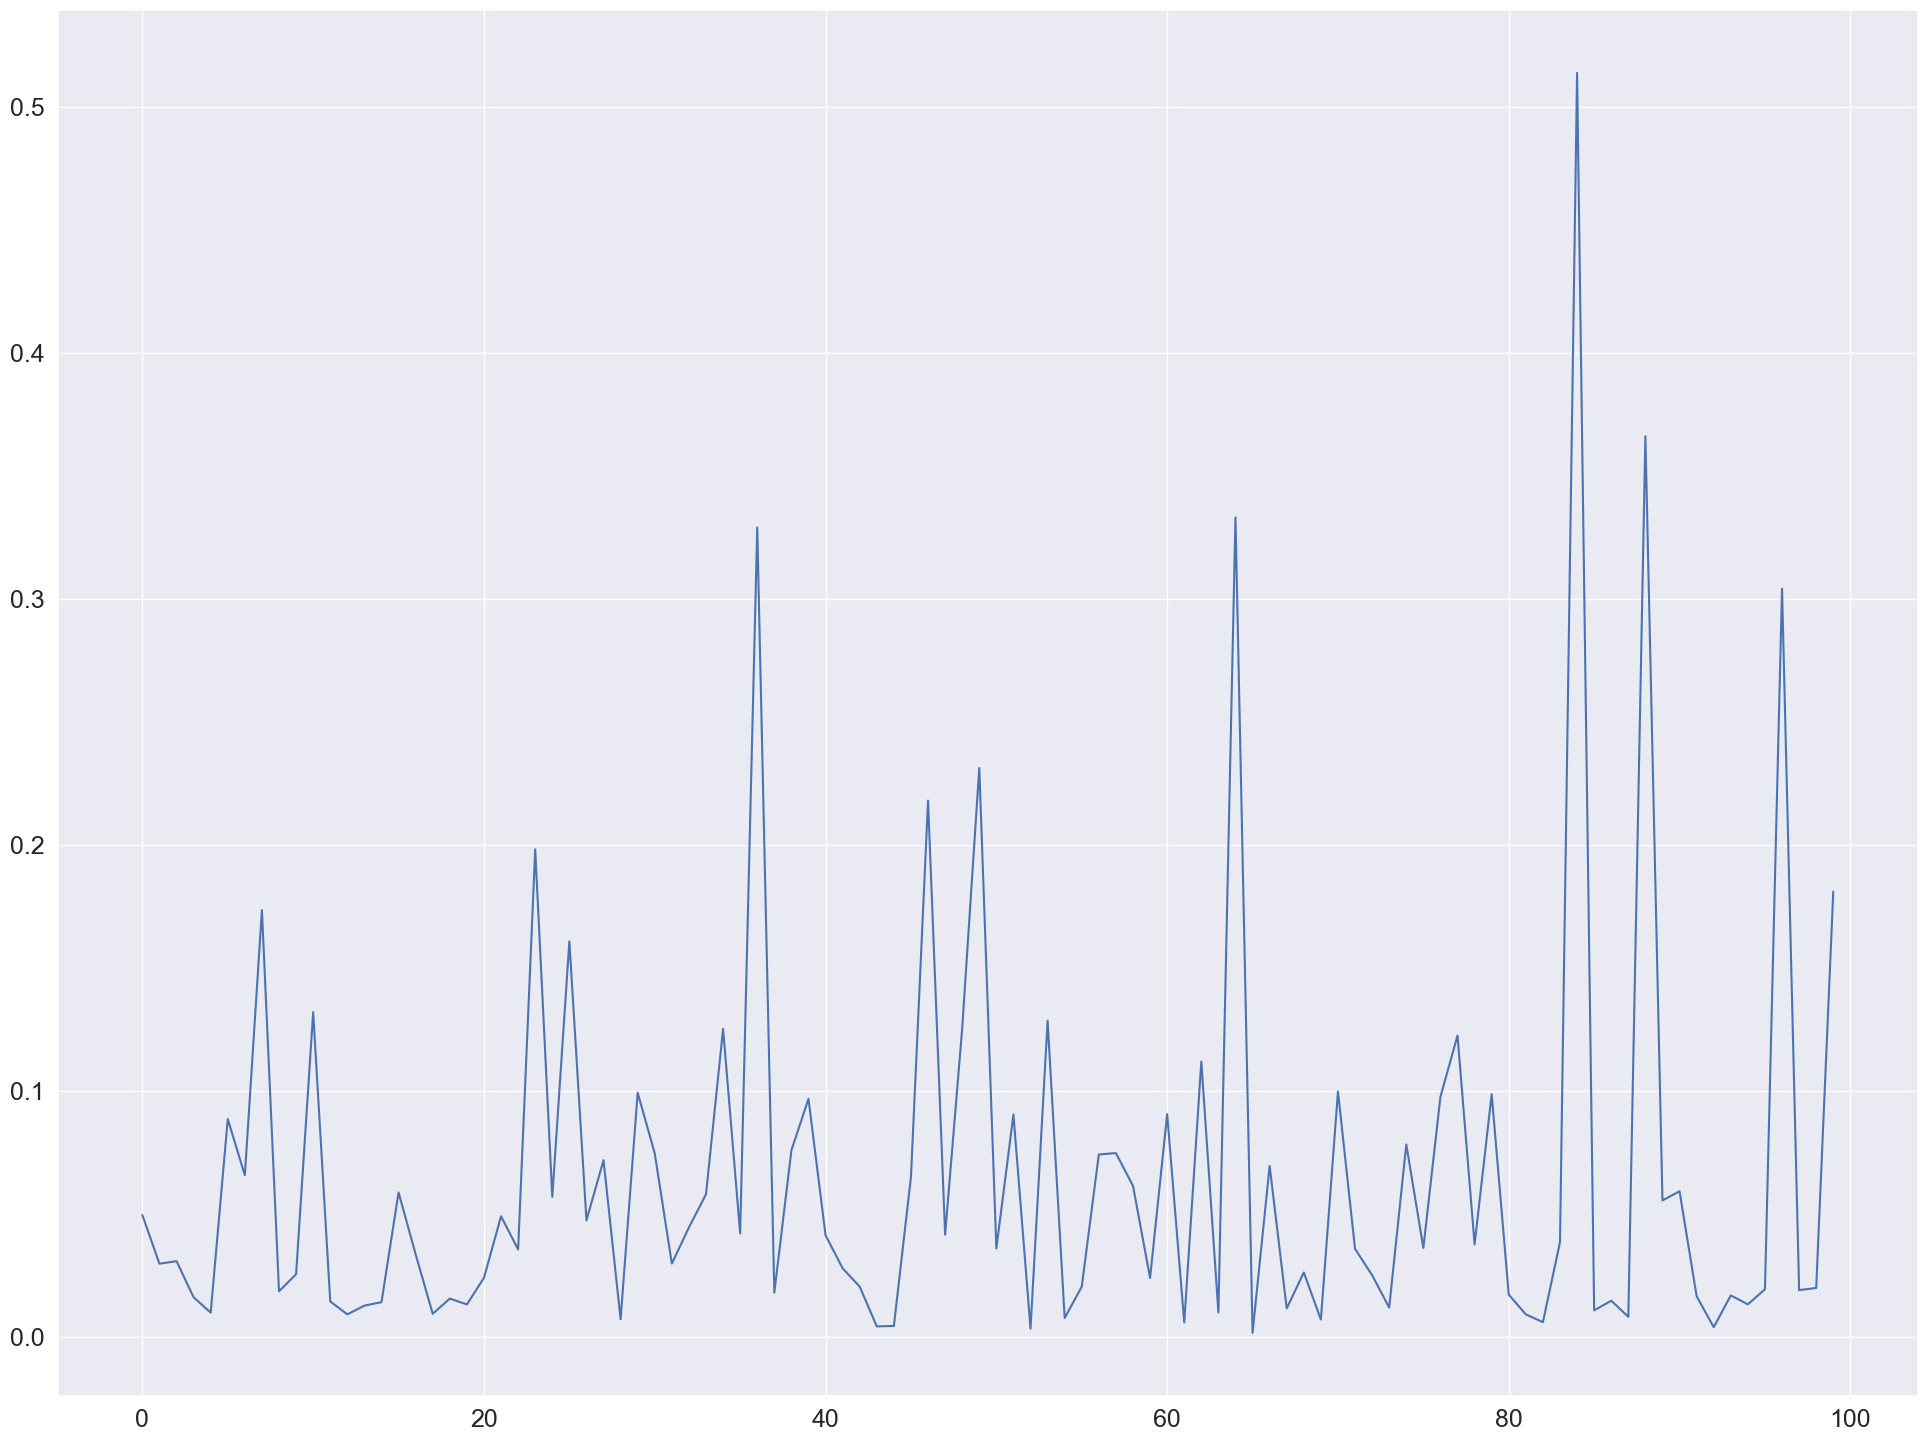

In [11]:
total_loss_list=[]
for i in result:
    total_loss_list.append(i[-1].detach().cpu().numpy())
plt.plot(total_loss_list)

In [12]:
z_fix[0]

tensor([ 0.9907,  0.3349,  1.1497, -0.5498, -0.1046,  2.0104, -0.7886, -0.1246,
         0.4382,  0.1238,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000], device='cuda:0')

In [13]:
result_std=torch.zeros((5,100))
for i in range(len(result)):
    result_std[0,i]=result[i][0].item()
    result_std[1,i]=result[i][1].item()
    result_std[2,i]=result[i][2].item()
    result_std[3,i]=result[i][3].item()
    result_std[4,i]=result[i][4].item()

In [14]:
result_std.std(dim=1)

tensor([0.0185, 0.0186, 0.0180, 0.0197, 0.0236])